# Implementing the Factor and Backtest paper, followed by Arbitrage Paper

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pyfinance.ols import PandasRollingOLS
import yfinance as yf
import fredapi

# Set up FRED API
fred = fredapi.Fred(api_key="fee3c07857d2bc6b2929b863848ac515")

## GETTING THE DATA


In [3]:
# Fetch VMC stock data
vmc_stock = yf.download("VMC", start="1976-01-01", end="2022-12-31")

# Fetch macro factors
tax_collections = fred.get_series("W006RC1Q027SBEA", start="1976-01-01", end="2022-12-31")
pmi_data = fred.get_series('IPMAN', start_date='2010-01-01', end_date='2022-12-31')
banks_performance = yf.download("^BKX", start="1976-01-01", end="2022-12-31")
interest_rate_futures = fred.get_series("T10Y2Y", start="2010-01-01", end="2022-12-31")


# GDP growth rate (quarterly)
gdp_growth_rate = fred.get_series("A191RL1Q225SBEA", start="1976-01-01", end="2022-12-31")

# Inflation rate - US CPI (quarterly)
inflation_rate = fred.get_series("CPIAUCSL", start="1976-01-01", end="2022-12-31")

# Unemployment rate (monthly)
unemployment_rate = fred.get_series("UNRATE", start="1976-01-01", end="2022-12-31")

#Fed rate
fed_rate = fred.get_series("FEDFUNDS", start="1976-01-01", end="2022-12-31")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Normalize the data and changing frequency to monthly

In [5]:
# Resample and interpolate tax_collections
tax_collections_daily = tax_collections.resample('D').interpolate()
tax_collections_monthly = tax_collections_daily.resample('M').mean()

# Resample pmi_data
pmi_data_monthly = pmi_data.resample('M').mean()

#resample inflation
inflation_rate_monthly = inflation_rate.resample('M').mean()

#resample unemployment
unemployment_rate_monthly = unemployment_rate.resample('M').mean()

#resample fed rate
fed_rate_monthly = fed_rate.resample('M').mean()


# Resample banks_performance
banks_performance_monthly = banks_performance['Close'].resample('M').mean()

# Resample interest_rate_futures
interest_rate_futures_monthly = interest_rate_futures.resample('M').mean()

# Resample vmc_stock
vmc_stock_monthly = vmc_stock['Close'].resample('M').mean()

# Resample gdp_growth_rate
gdp_growth_rate_daily = gdp_growth_rate.resample('D').interpolate()
gdp_growth_rate_monthly = gdp_growth_rate.resample('M').mean()

# Set the start date as 1993-01-01
start_date = '1993-01-01'

# Trim data to start from the start_date
tax_collections_monthly = tax_collections_monthly.loc[start_date:]
pmi_data_monthly = pmi_data_monthly.loc[start_date:]
banks_performance_monthly = banks_performance_monthly.loc[start_date:]
interest_rate_futures_monthly = interest_rate_futures_monthly.loc[start_date:]
vmc_stock_monthly = vmc_stock_monthly.loc[start_date:]


# Merge data into a single dataframe
data = pd.concat([vmc_stock_monthly, tax_collections_monthly, pmi_data_monthly, banks_performance_monthly, interest_rate_futures_monthly, gdp_growth_rate_monthly, fed_rate_monthly, unemployment_rate_monthly, inflation_rate_monthly], axis=1)
data.columns = ["VMC", "TaxCollections", "PMI", "BanksPerformance", "InterestRateFutures", "GdpGrowthRate", "FedRate", "UnemploymentRate", "CPI"]
data.dropna(inplace=True)


# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

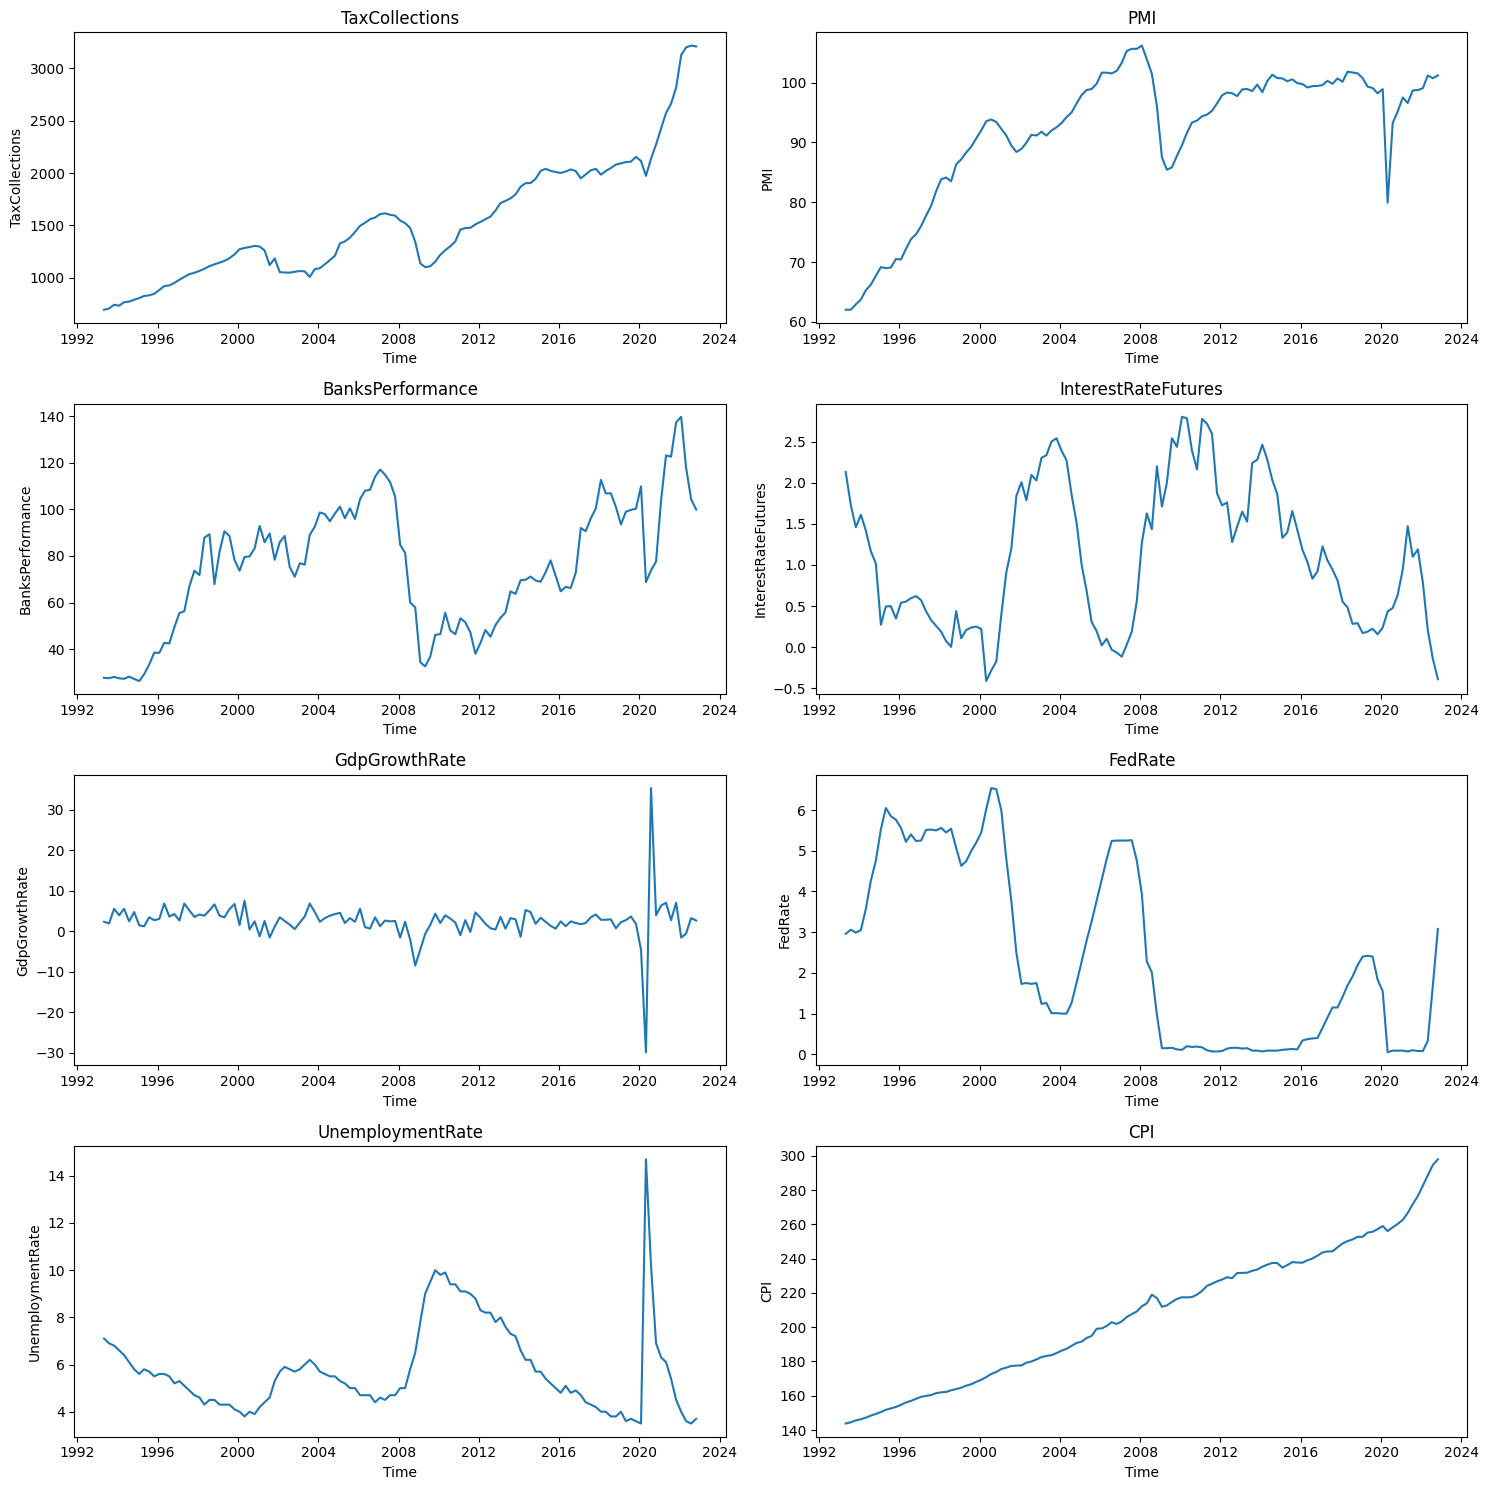

In [36]:
#Visualizing the data 

features = ["TaxCollections", "PMI", "BanksPerformance", "InterestRateFutures", "GdpGrowthRate", "FedRate", "UnemploymentRate", "CPI"]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()

for idx, feature in enumerate(features):
    axes[idx].plot(data.index, data[feature])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel(feature)

# Adjust the layout of the subplots to avoid overlapping
plt.tight_layout()
plt.show()



## With and without PCA | Different ML models performance

### Why PCA and What is it?

#### PCA (Principal Component Analysis) is a dimensionality reduction technique that aims to project data onto a lower-dimensional space while retaining as much variance as possible. The primary goal of PCA is to identify the linear combinations of the original features that capture the most variance in the data.

In [15]:
# Define the models
models = {
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Function to evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results[name] = {"R-squared": r2, "Mean Squared Error": mse, "Root Mean Squared Error": rmse}
    return results

# Train-test split (without PCA)
X = data_scaled.drop("VMC", axis=1)
y = data_scaled["VMC"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate models without PCA
results_without_pca = evaluate_models(models, X_train, X_test, y_train, y_test)

# Perform PCA
pca = PCA()
reduced_data = pca.fit_transform(data_scaled.drop("VMC", axis=1))
reduced_data = pd.DataFrame(reduced_data, index=data_scaled.index)

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components retained: {n_components}")

# Train-test split (with PCA)
X_pca = reduced_data.iloc[:, :n_components]
y_pca = data_scaled["VMC"]

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

# Evaluate models with PCA
results_with_pca = evaluate_models(models, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

# Print results
print("\nResults without PCA:")
for model, metrics in results_without_pca.items():
    print(f"{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

print("\nResults with PCA:")
for model, metrics in results_with_pca.items():
    print(f"{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


Number of components retained: 5

Results without PCA:
XGBoost:
  R-squared: 0.9514026912807314
  Mean Squared Error: 0.05707709437609517
  Root Mean Squared Error: 0.23890812957305402
Linear Regression:
  R-squared: 0.9146972838200186
  Mean Squared Error: 0.1001872595469796
  Root Mean Squared Error: 0.3165237108764201
Random Forest:
  R-squared: 0.9483129815132837
  Mean Squared Error: 0.060705930223983066
  Root Mean Squared Error: 0.24638573461948454

Results with PCA:
XGBoost:
  R-squared: 0.931596805864439
  Mean Squared Error: 0.08033892555358217
  Root Mean Squared Error: 0.28344122063239524
Linear Regression:
  R-squared: 0.8568242319043571
  Mean Squared Error: 0.16815862942477613
  Root Mean Squared Error: 0.4100714930652656
Random Forest:
  R-squared: 0.9344693731458461
  Mean Squared Error: 0.07696512156847497
  Root Mean Squared Error: 0.27742588482056785


### PCA might not be the best approach, and here's why:

#### We have a relatively small number of features (8), so the computational complexity reduction might not be significant enough to justify the information loss incurred by PCA. The PCA transformation is linear, and if the relationship between the original features and the target variable is non-linear, PCA might not capture this relationship effectively, resulting in a reduced model performance. PCA assumes that the principal components with lower variance contain less valuable information, but this assumption might not hold in your dataset. Some of the low-variance components might still be important in predicting the target variable.

#### In this specific case, PCA retained 5 components, which cumulatively explained 95% of the total variance in the data. The remaining columns (FedRate, UnemploymentRate, and CPI) were dropped because the components representing them did not capture much of the remaining variance in the data. This means that these factors were less relevant in explaining the variance within the dataset, which is evident from their correlation

### Correlations 

In [25]:
# Analyzing correlations
correlations = data_scaled.corr()['VMC'].drop('VMC')
print("\nCorrelations between VMC and other factors:")
print(correlations)


Correlations between VMC and other factors:
TaxCollections         0.914509
PMI                    0.618699
BanksPerformance       0.717002
InterestRateFutures   -0.287294
GdpGrowthRate         -0.029472
FedRate               -0.381741
UnemploymentRate      -0.282978
CPI                    0.846806
Name: VMC, dtype: float64


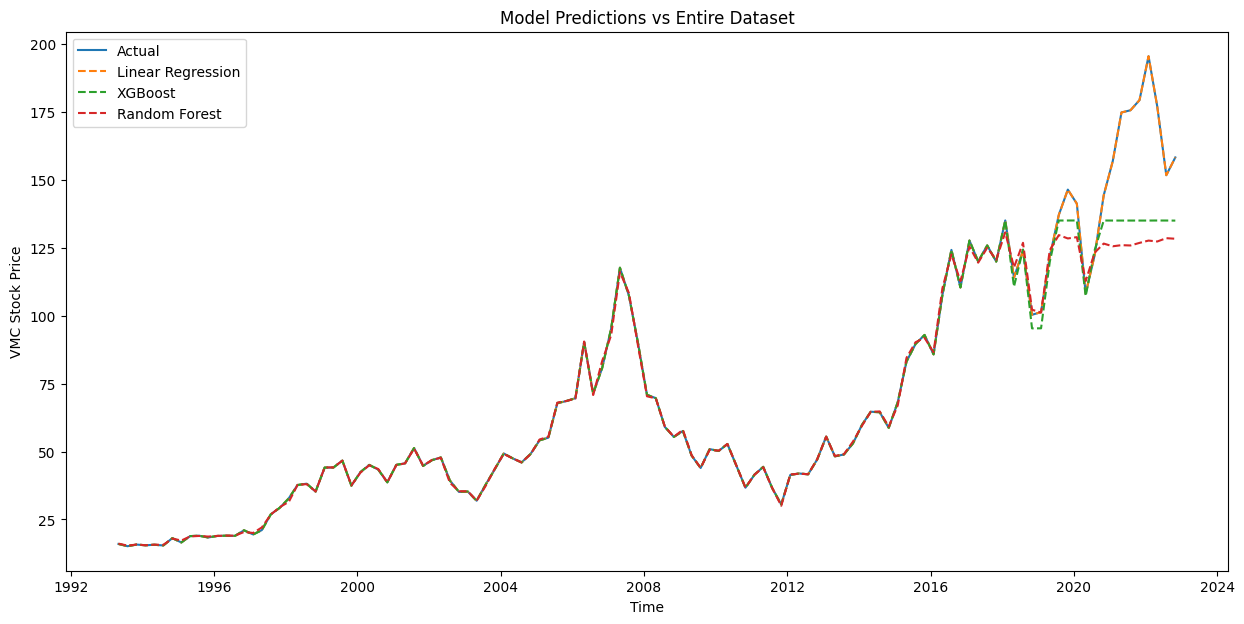

In [35]:
# Make predictions on the entire dataset for each model
y_pred_lr = lr_model.predict(data_scaled)
y_pred_xgb = xgb_model.predict(data_scaled)
y_pred_rf = rf_model.predict(data_scaled)

# Convert the predictions and actual data back to their original scale
y_pred_lr_orig = scaler.inverse_transform(np.column_stack((y_pred_lr, np.zeros(y_pred_lr.shape[0]*8).reshape(-1, 8))))[:, 0]
y_pred_xgb_orig = scaler.inverse_transform(np.column_stack((y_pred_xgb, np.zeros(y_pred_xgb.shape[0]*8).reshape(-1, 8))))[:, 0]
y_pred_rf_orig = scaler.inverse_transform(np.column_stack((y_pred_rf, np.zeros(y_pred_rf.shape[0]*8).reshape(-1, 8))))[:, 0]
y_orig = scaler.inverse_transform(np.column_stack((data_scaled["VMC"], np.zeros(data_scaled.shape[0]*8).reshape(-1, 8))))[:, 0]

# Plot the entire dataset with predictions for each model
plt.figure(figsize=(15, 7))
plt.plot(data_scaled.index, y_orig, label="Actual")
plt.plot(data_scaled.index, y_pred_lr_orig, label="Linear Regression", linestyle='dashed')
plt.plot(data_scaled.index, y_pred_xgb_orig, label="XGBoost", linestyle='dashed')
plt.plot(data_scaled.index, y_pred_rf_orig, label="Random Forest", linestyle='dashed')
plt.title("Model Predictions vs Entire Dataset")
plt.xlabel("Time")
plt.ylabel("VMC Stock Price")
plt.legend()
plt.show()


# Applying the backtest paper

#### The authors propose a new backtesting protocol consisting of five key steps:
#### a. Partition the data into in-sample (training) and out-of-sample (testing) subsets.
#### b. Train the ML model on the in-sample data, and evaluate its performance using out-of-sample data.
#### c. Implement a walk-forward methodology, incrementally expanding the in-sample data and retraining the model. This approach helps ensure that the model remains up-to-date.
#### d. Apply a multiple hypothesis testing framework to assess the statistical significance of the backtest results.
#### e. Test the robustness of the model by examining its performance under different market conditions.

In [17]:
# Partition the data into in-sample - training and out-of-sample testing subsets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the models
xgb_model = XGBRegressor(objective='reg:squarederror')
rf_model = RandomForestRegressor()
lr_model = LinearRegression()

# Initialize lists to store results
xgb_mse_list = []
rf_mse_list = []
lr_mse_list = []

# Implement a walk-forward methodology, incrementally expanding the in-sample data and retraining the model
for train_index, test_index in tscv.split(data_scaled):
    X_train, X_test = data_scaled.iloc[train_index], data_scaled.iloc[test_index]
    y_train, y_test = data_scaled["VMC"].iloc[train_index], data_scaled["VMC"].iloc[test_index]

    # Train the XGBoost model on in-sample data
    xgb_model.fit(X_train, y_train)
    # Evaluate its performance using out-of-sample data
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    xgb_mse_list.append(mse_xgb)

    # Train the Random Forest model on the in-sample data
    rf_model.fit(X_train, y_train)
    # Evaluate the performance using out-of-sample data
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rf_mse_list.append(mse_rf)
    
    # Train the Linear Regression model on the in-sample data
    lr_model.fit(X_train, y_train)
    # Evaluate its performance using out-of-sample data
    y_pred_lr = lr_model.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    lr_mse_list.append(mse_lr)

# Compute the average MSE for all models
avg_mse_xgb = np.mean(xgb_mse_list)
avg_mse_rf = np.mean(rf_mse_list)
avg_mse_lr = np.mean(lr_mse_list)

print("Average MSE for XGBoost:", avg_mse_xgb)
print("Average MSE for Random Forest:", avg_mse_rf)
print("Average MSE for Linear Regression:", avg_mse_lr)
print()

# Apply a multiple hypothesis testing framework
# Here, we'll use a simple t-test as an example
from scipy.stats import ttest_rel

xgb_lr_t_stat, xgb_lr_p_value = ttest_rel(xgb_mse_list, lr_mse_list)
xgb_rf_t_stat, xgb_rf_p_value = ttest_rel(xgb_mse_list, rf_mse_list)
lr_rf_t_stat, lr_rf_p_value = ttest_rel(lr_mse_list, rf_mse_list)

print("T-test results between XGBoost and Linear Regression:")
print("P-value:", xgb_lr_p_value)
print()

print("T-test results between XGBoost and Random Forest:")
print("P-value:", xgb_rf_p_value)
print()

print("T-test results between Linear Regression and Random Forest:")
print("P-value:", lr_rf_p_value)


Average MSE for XGBoost: 0.15719708027229745
Average MSE for Random Forest: 0.24191494824721657
Average MSE for Linear Regression: 5.294906296383315e-31

T-test results between XGBoost and Linear Regression:
P-value: 0.16397382862338178

T-test results between XGBoost and Random Forest:
P-value: 0.03399611604370107

T-test results between Linear Regression and Random Forest:
P-value: 0.08431261811278411


## Analysis 

### In summary, based on the average MSE values, Linear Regression appears to perform the best among the three models, while XGBoost also shows relatively good performance compared to Random Forest. However, the t-test results suggest that the differences in performance between the models are not strongly statistically significant.

## Arbitrage Paper logic and implementation

## Download multiple stocks with various features to implement this part !

### Collect historical stock and financial data, including market returns and macroeconomic variables. 
### Clean and preprocess data, calculating excess returns.
### Create factors capturing known stock return anomalies, such as value, size, and momentum.
### Build portfolios with high and low factor exposure, tracking performance over time.
### Incorporate arbitrage constraints like transaction costs and short selling restrictions.
### Evaluate portfolio and factor return performance using metrics like Sharpe ratio and Jensen's alpha.
### Perform Monte Carlo simulations to test results' robustness under different conditions.
### Create visualizations to display portfolios' performance, factor persistence, and arbitrage constraints impact.

In [ ]:

# ... can use the previous data fetching and preprocessing code but for multiple stocks

# Factor construction

# Value factor: Get important ratios
ratios = pd.DataFrame(index=data_scaled.index)

for stock in stock_list:
    stock_prices = yf.download(stock, start=start_date, end=end_date)["Close"].resample("M").mean()
    stock_earnings = fredapi.get_series("some_earnings_data_series", start=start_date, end=end_date).resample("M").mean()
    ratios[stock] = stock_prices / stock_earnings

# Size factor: Market capitalization
market_caps = pd.DataFrame(index=data_scaled.index)
for stock in stock_list:
    stock_prices = yf.download(stock, start=start_date, end=end_date)["Close"].resample("M").mean()
    stock_shares_outstanding = fredapi.get_series("some_shares_outstanding_data_series", start=start_date, end=end_date).resample("M").mean()
    market_caps[stock] = stock_prices * stock_shares_outstanding

# Momentum factor: Past 12-month returns
momentum = pd.DataFrame(index=data_scaled.index)
for stock in stock_list:
    stock_prices = yf.download(stock, start=start_date, end=end_date)["Close"].resample("M").mean()
    momentum[stock] = stock_prices.pct_change(12)

# Portfolio construction
# Long stocks with high factor exposure and short stocks with low factor exposure
long_short_portfolios = {}
for factor_name, factor_data in [("Value", ratios), ("Size", market_caps), ("Momentum", momentum)]:
    long_short_portfolio = pd.DataFrame(index=factor_data.index)
    long_short_portfolio["Long"] = factor_data.rank(axis=1, ascending=False).apply(lambda x: (x <= 5).astype(int), axis=1).sum(axis=1)
    long_short_portfolio["Short"] = factor_data.rank(axis=1, ascending=True).apply(lambda x: (x <= 5).astype(int), axis=1).sum(axis=1) * -1
    long_short_portfolio["Net"] = long_short_portfolio["Long"] + long_short_portfolio["Short"]
    long_short_portfolios[factor_name] = long_short_portfolio

# Model evaluation
for factor_name, long_short_portfolio in long_short_portfolios.items():
    print(f"Factor: {factor_name}")
    print("Average net return:", long_short_portfolio["Net"].mean())
    print("Sharpe ratio:", long_short_portfolio["Net"].mean() / long_short_portfolio["Net"].std())
    print()


## Further work on code and extension needed on Arbitrage paper

# Summary of 3 papers 

## Paper 1 - Arnott et al. (2020) - "A Backtesting Protocol in the Era of Machine Learning":

Importance of robust backtesting: The paper emphasizes the need for a rigorous backtesting framework in the era of machine learning to avoid overfitting and false discoveries.
Six principles for effective backtesting: The authors outline six principles, including out-of-sample testing, parameter reduction, controlling for data snooping, performance measurement, considering transaction costs, and economic intuition.
Machine learning challenges: The paper highlights that machine learning poses unique challenges, such as overfitting and multiple testing issues, which need to be addressed in backtesting protocols.
Importance of out-of-sample testing: The authors stress the importance of out-of-sample testing to ensure that the discovered relationships are not spurious and have true predictive power.
Combining machine learning and economic intuition: The paper argues that combining machine learning techniques with economic intuition can lead to more effective investment strategies.

## Paper 2 - Kozak et al. (2020) - "Interpreting Factor Models":

Economic forces in factor models: The paper investigates the economic forces that drive factor models, focusing on understanding the relationship between macroeconomic factors and asset returns.
Cash flow and discount rate news components: The authors present a method for decomposing factors into cash flow and discount rate news components, offering a deeper understanding of the underlying drivers of factor returns.
Empirical analysis: The paper conducts an empirical analysis of popular factors to demonstrate the proposed decomposition method's effectiveness in understanding the sources of factor returns.
Importance of interpretation: The study emphasizes the importance of interpreting factor models to provide meaningful insights into the relationship between asset returns and macroeconomic factors.
Better understanding of factors: The findings can help investors better understand the sources of factor returns, which can, in turn, lead to improved investment strategies.

## Paper 3 - Limits of Arbitrage (Shleifer and Vishny):

Anomalies in stock prices: The paper discusses the persistence of factor returns and observations of anomalies in stock prices, offering a practical model to understand these phenomena.
Limits of arbitrage: The authors argue that limits to arbitrage, such as risks, costs, and constraints faced by arbitrageurs, can cause inefficiencies in financial markets and explain the persistence of anomalies.
Noise trader risk: The paper highlights noise trader risk, which arises from the unpredictable behavior of non-professional investors, as a potential source of limits to arbitrage.
Fundamentals-based model: The authors present a model that considers the interplay between arbitrageurs and noise traders, providing insights into the persistence of anomalies and the role of arbitrage in financial markets.
Practical implications: The paper's findings can help investors understand why market inefficiencies persist and inform the design of investment strategies that account for the limits of arbitrage.

